## Import Library

In [1]:
!pip install transformers

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import SegformerForSemanticSegmentation
import glob
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import shutil
import matplotlib.pyplot as plt
from transformers import get_cosine_schedule_with_warmup
from tqdm import tqdm
import numpy as np

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Class Dataset

In [4]:
class BreastCancerDataset(Dataset):
    def __init__(self, root='/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT', is_train=True, transform=None):
        self.categories = ["benign", "malignant", "normal"]
        self.transform = transform
        self.path = glob.glob("{}/*/*_mask.png".format(root))

        random.seed(159)
        random.shuffle(self.path)
        if is_train:
            self.path = self.path[:int(len(self.path) * 0.85)]
        else:
            self.path = self.path[int(len(self.path) * 0.85):]
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, index):
        image = cv2.imread(self.path[index].replace("_mask.png", ".png"))
        mask = cv2.imread(self.path[index], cv2.IMREAD_GRAYSCALE)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask[mask == 255] = 1

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        return image.float(), mask.float()

In [5]:
size = 512
train_transform = A.Compose([
    A.Resize(size, size),
    # A.RandomRotate90(),
    # A.GaussianBlur(),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    # A.CoarseDropout(max_height=25, max_width=25, fill_value=255),
    # A.ElasticTransform(alpha=1.0),
    A.HorizontalFlip(),
    A.Perspective(scale=(0.05, 0.1)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

## UnNormalized

In [6]:
class UnNormalized(object):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unNorm = UnNormalized()

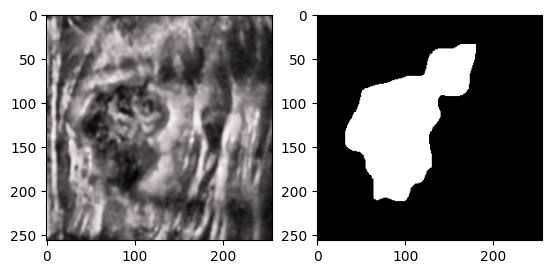

In [15]:
train_dataset = BreastCancerDataset(transform=train_transform)
test_dataset = BreastCancerDataset(is_train=False, transform=test_transform)
image, mask = train_dataset[-1]
plt.subplot(1, 2, 1)
plt.imshow(unNorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

## AverageMeter

In [16]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n = 1):
        self.val += val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Show Loss

In [17]:
def plot_segmentation_metrics(train_loss, val_loss, train_mean_iou=None, val_mean_iou=None, 
                              train_dice_score=None, val_dice_score=None):
    """
    Plot training and validation metrics (loss, mean IoU, Dice score) over epochs.

    Args:
    - train_loss (list): List of training loss values over epochs.
    - val_loss (list): List of validation loss values over epochs.
    - train_mean_iou (list, optional): List of training mean IoU values over epochs.
    - val_mean_iou (list, optional): List of validation mean IoU values over epochs.
    - train_dice_score (list, optional): List of training Dice score values over epochs.
    - val_dice_score (list, optional): List of validation Dice score values over epochs.
    """
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Val Loss')
    plt.title('Training and Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Mean IoU (if available)
    if train_mean_iou and val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Training Mean IoU')
        plt.plot(epochs, val_mean_iou, 'b', label='Val Mean IoU')
        plt.title('Training and Val Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plotting the Dice Score (if available)
    if train_dice_score and val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Training Dice Score')
        plt.plot(epochs, val_dice_score, 'b', label='Val Dice Score')
        plt.title('Training and Val Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

## Calculate Intersection And Union

In [18]:
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

## Train

In [19]:
upsample = nn.Upsample(scale_factor=4, mode='bilinear')

In [20]:
def train(num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    train_dataset = BreastCancerDataset(transform=train_transform)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers
    )
    
    test_dataset = BreastCancerDataset(is_train=False, transform=test_transform)
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        num_workers=n_workers
    )

    version = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(version)
    
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-4)
    
    num_epoch = len(train_loader)
    
    scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=num_epoch*epochs, power=0.9)

    
    if os.path.isdir(checkpoint):
        shutil.rmtree(checkpoint)
    os.makedirs(checkpoint)
    
    if not os.path.isdir(saved_model):
        os.makedirs(saved_model)
    
    writer = SummaryWriter(checkpoint)
    
    train_loss = []
    test_loss = []
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    train_loss_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    
    no_improvement_counter = 0
    patience = 10
    best_mIoU = -1
    
    for epoch in range(epochs):
        model.train()
        train_loss_meter.reset()
        test_loss_meter.reset()
        intersection_meter.reset()
        union_meter.reset()
        
        progress_bar = tqdm(train_loader, colour='cyan')
        
        for i, (image, mask) in enumerate(progress_bar):
            image, mask = image.to(device), mask.to(device)
            
            output = model(image).logits
            output = upsample(output).squeeze()
            loss = criterion(output, mask)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_meter.update(loss.item())
            progress_bar.set_description(f"Train | Epoch {epoch + 1}/{epochs} | Loss {train_loss_meter.avg:.4f} | lr {optimizer.param_groups[0]['lr']}")
            writer.add_scalar("Train/Loss AVG", train_loss_meter.avg, num_epoch * epoch + i)
            writer.add_scalar("Train/Loss", loss.item(), num_epoch * epoch + i)
            scheduler.step()
        
        model.eval()
        with torch.no_grad():
            progress_bar = tqdm(iterable=test_loader, colour='yellow')
            
            for image, mask in progress_bar:
                image, mask = image.to(device), mask.to(device)
                
                output = model(image).logits
                output = upsample(output).squeeze()
                loss = criterion(output, mask)
                
                test_loss_meter.update(loss.item())
                output[output>=0.5] = 1
                output[output<0.5] = 0
                output = output.long()
                mask = mask.long()
                
                intersection, union, target = intersectionAndUnionGPU(output, mask, 2)           
                intersection_meter.update(intersection)
                union_meter.update(union)
                
                iou = intersection / (union + 1e-10)
                mean_iou = np.mean(iou.cpu().numpy())
                dice = 2 * intersection / (intersection + union + 1e-10)

                dice_value = dice.mean().item()
                
                intersection_meter.update(intersection)
                union_meter.update(union)
                test_loss_meter.update(loss.item())
                
                progress_bar.set_description(f"Val | Loss {loss.item():.4f} | mIoU: {mean_iou:.4f} | dice: {dice_value:.4f}")
            
            
            iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
            dice_class = 2 * intersection_meter.sum / (intersection_meter.sum + union_meter.sum + 1e-10)
            
            mIoU = iou_class.mean().item()
            mDice = dice_class.mean().item()
            print(f"Val | Loss {test_loss_meter.avg:.4f} | mIoU: {mIoU:.4f} | dice: {mDice:.4f}")
            
            writer.add_scalar("Val/Loss", test_loss_meter.avg, epoch)
            writer.add_scalar("Val/mIoU", mIoU, epoch)
            writer.add_scalar("Val/dice", mDice, epoch)
            
            checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch + 1,
                "mIoU": mIoU
            }
            
            torch.save(checkpoint, os.path.join(saved_model, "last.pt"))
            
            if mIoU > best_mIoU:
                best_mIoU = mIoU
                torch.save(checkpoint, os.path.join(saved_model, "best.pt"))
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1
              
            train_loss.append(train_loss_meter.avg)
            test_loss.append(test_loss_meter.avg)
            
            if no_improvement_counter > patience:
                print("Early stopping!")
                break
    
    plot_segmentation_metrics(train_loss, test_loss)


In [21]:
torch.cuda.empty_cache()

In [ ]:
num_class = 1
n_workers = os.cpu_count()
print(n_workers)
batch_size = 16
lr = 1e-4
epochs = 50
checkpoint = "/kaggle/working/tensorboard"
saved_model = "/kaggle/working/saved_model"

train(num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model)

4


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/190M [00:00<?, ?B/s]

  0%|          | 0/42 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train | Epoch 1/50 | Loss 0.5056 | lr 9.824112942991279e-05: 100%|██████████| 42/42 [01:12<00:00,  1.46s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train | Epoch 1/50 | Loss 0.5056 | lr 9.824112942991279e-05: 100%|██████████| 42/42 [01:12<00:00,  1.72s/it]
Val | Loss 0.3380 | mIoU: 0.6932 | dice: 0.8073: 100%|██████████| 8/8 [00:02<00:00,  3.59it/s]


Val | Loss 0.3289 | mIoU: 0.6996 | dice: 0.8047


Train | Epoch 2/50 | Loss 0.2751 | lr 9.64357235106179e-05: 100%|██████████| 42/42 [01:10<00:00,  1.68s/it] 
Val | Loss 0.3124 | mIoU: 0.7687 | dice: 0.8644: 100%|██████████| 8/8 [00:01<00:00,  4.32it/s]


Val | Loss 0.3035 | mIoU: 0.7427 | dice: 0.8414


Train | Epoch 3/50 | Loss 0.1974 | lr 9.462655399104816e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it]
Val | Loss 0.2816 | mIoU: 0.7277 | dice: 0.8347: 100%|██████████| 8/8 [00:01<00:00,  4.68it/s]


Val | Loss 0.2464 | mIoU: 0.7579 | dice: 0.8526


Train | Epoch 4/50 | Loss 0.1607 | lr 9.281353272469786e-05: 100%|██████████| 42/42 [01:10<00:00,  1.68s/it]
Val | Loss 0.2659 | mIoU: 0.6952 | dice: 0.8082: 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]


Val | Loss 0.2136 | mIoU: 0.7088 | dice: 0.8121


Train | Epoch 5/50 | Loss 0.1364 | lr 9.099656753777437e-05: 100%|██████████| 42/42 [01:10<00:00,  1.68s/it]
Val | Loss 0.3164 | mIoU: 0.7098 | dice: 0.8214: 100%|██████████| 8/8 [00:01<00:00,  4.37it/s]


Val | Loss 0.2243 | mIoU: 0.7692 | dice: 0.8609


Train | Epoch 6/50 | Loss 0.1249 | lr 8.917556195151512e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it]
Val | Loss 0.3110 | mIoU: 0.7012 | dice: 0.8138: 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]


Val | Loss 0.2288 | mIoU: 0.7374 | dice: 0.8367


Train | Epoch 7/50 | Loss 0.1159 | lr 8.735041487860368e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it]
Val | Loss 0.3230 | mIoU: 0.6161 | dice: 0.7393: 100%|██████████| 8/8 [00:01<00:00,  4.60it/s]


Val | Loss 0.2083 | mIoU: 0.7110 | dice: 0.8137


Train | Epoch 8/50 | Loss 0.1063 | lr 8.552102029061001e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it]
Val | Loss 0.2691 | mIoU: 0.7553 | dice: 0.8540: 100%|██████████| 8/8 [00:01<00:00,  4.63it/s]


Val | Loss 0.1946 | mIoU: 0.7561 | dice: 0.8508


Train | Epoch 9/50 | Loss 0.1018 | lr 8.36872668529313e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it] 
Val | Loss 0.2527 | mIoU: 0.7954 | dice: 0.8821: 100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


Val | Loss 0.2066 | mIoU: 0.7726 | dice: 0.8633


Train | Epoch 10/50 | Loss 0.0957 | lr 8.184903752318806e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it]
Val | Loss 0.2366 | mIoU: 0.7276 | dice: 0.8336: 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]


Val | Loss 0.1812 | mIoU: 0.7532 | dice: 0.8480


Train | Epoch 11/50 | Loss 0.0978 | lr 8.00062091084076e-05: 100%|██████████| 42/42 [01:10<00:00,  1.68s/it] 
Val | Loss 0.2638 | mIoU: 0.6636 | dice: 0.7820: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]


Val | Loss 0.1757 | mIoU: 0.7473 | dice: 0.8433


Train | Epoch 12/50 | Loss 0.0818 | lr 7.815865177560108e-05: 100%|██████████| 42/42 [01:10<00:00,  1.68s/it]
Val | Loss 0.3333 | mIoU: 0.5761 | dice: 0.6998: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


Val | Loss 0.1866 | mIoU: 0.7335 | dice: 0.8324


Train | Epoch 13/50 | Loss 0.0764 | lr 7.630622850946967e-05: 100%|██████████| 42/42 [01:10<00:00,  1.68s/it]
Val | Loss 0.2993 | mIoU: 0.7756 | dice: 0.8694: 100%|██████████| 8/8 [00:01<00:00,  4.60it/s]


Val | Loss 0.1896 | mIoU: 0.7803 | dice: 0.8688


Train | Epoch 14/50 | Loss 0.0760 | lr 7.444879450994227e-05: 100%|██████████| 42/42 [01:10<00:00,  1.68s/it]
Val | Loss 0.2645 | mIoU: 0.7245 | dice: 0.8314: 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]


Val | Loss 0.1769 | mIoU: 0.7758 | dice: 0.8651


Train | Epoch 15/50 | Loss 0.0684 | lr 7.258619652100879e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it]
Val | Loss 0.2975 | mIoU: 0.8118 | dice: 0.8928: 100%|██████████| 8/8 [00:01<00:00,  4.36it/s]


Val | Loss 0.1857 | mIoU: 0.7805 | dice: 0.8688


Train | Epoch 16/50 | Loss 0.0743 | lr 7.071827208082315e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it]
Val | Loss 0.3635 | mIoU: 0.5974 | dice: 0.7213: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]


Val | Loss 0.1912 | mIoU: 0.7507 | dice: 0.8462


Train | Epoch 17/50 | Loss 0.0673 | lr 6.884484868124833e-05: 100%|██████████| 42/42 [01:10<00:00,  1.68s/it]
Val | Loss 0.3025 | mIoU: 0.6773 | dice: 0.7937: 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]


Val | Loss 0.1787 | mIoU: 0.7660 | dice: 0.8579


Train | Epoch 18/50 | Loss 0.0614 | lr 6.696574282282402e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it]
Val | Loss 0.3170 | mIoU: 0.7094 | dice: 0.8202: 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]


Val | Loss 0.1844 | mIoU: 0.7861 | dice: 0.8727


Train | Epoch 19/50 | Loss 0.0661 | lr 6.508075894846375e-05: 100%|██████████| 42/42 [01:11<00:00,  1.69s/it]
Val | Loss 0.3576 | mIoU: 0.6274 | dice: 0.7500: 100%|██████████| 8/8 [00:01<00:00,  4.65it/s]


Val | Loss 0.1851 | mIoU: 0.7711 | dice: 0.8616


Train | Epoch 20/50 | Loss 0.0605 | lr 6.318968823589318e-05: 100%|██████████| 42/42 [01:10<00:00,  1.68s/it]
Val | Loss 0.2483 | mIoU: 0.7585 | dice: 0.8564: 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]


Val | Loss 0.1696 | mIoU: 0.7806 | dice: 0.8686


Train | Epoch 21/50 | Loss 0.0596 | lr 6.129230722477158e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it]
Val | Loss 0.3073 | mIoU: 0.6624 | dice: 0.7811: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]


Val | Loss 0.1732 | mIoU: 0.7772 | dice: 0.8661


Train | Epoch 22/50 | Loss 0.0568 | lr 5.938837624936619e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it] 
Val | Loss 0.4585 | mIoU: 0.6260 | dice: 0.7488: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]


Val | Loss 0.1969 | mIoU: 0.7640 | dice: 0.8563


Train | Epoch 23/50 | Loss 0.0598 | lr 5.7477637641288734e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it]
Val | Loss 0.5243 | mIoU: 0.5875 | dice: 0.7161: 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


Val | Loss 0.2084 | mIoU: 0.7724 | dice: 0.8628


Train | Epoch 24/50 | Loss 0.0563 | lr 5.555981365876605e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it] 
Val | Loss 0.5215 | mIoU: 0.6256 | dice: 0.7486: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]


Val | Loss 0.2005 | mIoU: 0.7750 | dice: 0.8642


Train | Epoch 25/50 | Loss 0.0530 | lr 5.363460408867995e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it] 
Val | Loss 0.3630 | mIoU: 0.6358 | dice: 0.7596: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


Val | Loss 0.1917 | mIoU: 0.7803 | dice: 0.8687


Train | Epoch 26/50 | Loss 0.0501 | lr 5.170168345445529e-05: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it] 
Val | Loss 0.4959 | mIoU: 0.5902 | dice: 0.7165: 100%|██████████| 8/8 [00:01<00:00,  4.63it/s]


Val | Loss 0.2119 | mIoU: 0.7607 | dice: 0.8537


Train | Epoch 27/50 | Loss 0.0515 | lr 4.976069774582066e-05: 100%|██████████| 42/42 [01:10<00:00,  1.68s/it] 
Val | Loss 0.4199 | mIoU: 0.6213 | dice: 0.7450: 100%|██████████| 8/8 [00:01<00:00,  4.61it/s]


Val | Loss 0.1951 | mIoU: 0.7765 | dice: 0.8655


Train | Epoch 28/50 | Loss 0.0997 | lr 4.966806224885522e-05:   5%|▍         | 2/42 [00:03<01:17,  1.94s/it]

## Inference

In [ ]:
def pred_show_image_grid(model_pth, device, test_dataset, num_classes, idx, num_imgs):
    # Load model checkpoint
    checkpoint = torch.load(model_pth)
    
    # Initialize and load model state
    model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(model_name)
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    # Load validation dataset
    
    images, orig_masks, pred_masks = [], [], []
    
    with torch.no_grad():
        for i in idx:
            ori_img, orig_mask = test_dataset[i]
            img = ori_img

            # Predict mask
            img = img.float().to(device).unsqueeze(0)
            # (B, 21, H, W) -> (B, 1, H, W) -> (B, H, W)
            pred_mask = upsample(model(img).logits).squeeze()
            pred_mask[pred_mask>=0.5] = 1
            pred_mask[pred_mask<0.5] = 0
            pred_mask = pred_mask.long().cpu().numpy()

            images.append(unNorm(ori_img).permute(1, 2, 0))
            orig_masks.append(orig_mask)
            pred_masks.append(pred_mask)

    
    # Combine images and masks for display
    images.extend(orig_masks)
    images.extend(pred_masks)
    
    # Plot images and masks
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, 3*num_imgs + 1):
        fig.add_subplot(3, num_imgs, i)
        plt.imshow(images[i - 1])
    plt.show()

In [ ]:
#Note: You must train the model before using this param
model_pth = "/kaggle/working/saved_model/best.pt"
num_classes = 1
device = "cuda" if torch.cuda.is_available() else "cpu" 
print("\n")
indexs = [4, 14, 24, 34, 44, 54, 64, 74, 84, 94]
print("indexs =", indexs)
print("\n")

#Show images
pred_show_image_grid(model_pth, device, test_dataset, num_classes, indexs, num_imgs= 10)